<a href="https://colab.research.google.com/github/ReddiSrujan/Artificial-Neural-Network/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ================================
# Load dataset
# ================================
file_path = "/content/NGA_west2_spectra-2.csv"
df = pd.read_csv(file_path)

# Define input (X) and output (Y) columns
input_cols = ['Earthquake Magnitude', 'Hypocenter Depth (km)', 'EpiD (km)', 'Vs30 (m/s) selected for analysis']
output_cols = df.columns[6:]  # All spectral response columns

n_inputs = len(input_cols)   # 4 input features
n_outputs = len(output_cols)  # Number of output features

n_inputs, n_outputs

(4, 112)

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))  # For input columns
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # For output columns

df[input_cols] = scaler_X.fit_transform(df[input_cols])
df[output_cols] = scaler_Y.fit_transform(df[output_cols])


# ================================
# Define Generator Model
# ================================
def define_generator(n_inputs=4, n_outputs=n_outputs):
    inputs = Input(shape=(n_inputs,))

    hidden1 = Dense(128)(inputs)
    hidden1 = BatchNormalization()(hidden1)
    hidden1 = LeakyReLU(0.2)(hidden1)

    hidden2 = Dense(256)(hidden1)
    hidden2 = BatchNormalization()(hidden2)
    hidden2 = LeakyReLU(0.2)(hidden2)

    hidden3 = Dense(512)(hidden2)
    hidden3 = BatchNormalization()(hidden3)
    hidden3 = LeakyReLU(0.2)(hidden3)

    output = Dense(n_outputs, activation='relu')(hidden3)  # Generate 112 spectral values

    model = Model(inputs=inputs, outputs=output)
    return model


# ================================
# Define Discriminator Model
# ================================
def define_discriminator(n_outputs=n_outputs):
    inputs = Input(shape=(n_outputs,))

    hidden1 = Dense(256)(inputs)
    hidden1 = LeakyReLU(0.2)(hidden1)
    hidden1 = Dropout(0.3)(hidden1)

    hidden2 = Dense(128)(hidden1)
    hidden2 = LeakyReLU(0.2)(hidden2)
    hidden2 = Dropout(0.3)(hidden2)

    hidden3 = Dense(32)(hidden2)
    hidden3 = LeakyReLU(0.2)(hidden3)
    hidden3 = Dropout(0.4)(hidden3)


    output = Dense(1, activation='sigmoid')(hidden3)  # Classifies real (1) vs fake (0)

    model = Model(inputs=inputs, outputs=output)
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# ================================
# Generate Real Samples
# ================================
def generate_real_samples(df, n):
    df_sample = df.sample(n)

    # Select input (X)
    X_real = df_sample[input_cols].values

    # Select corresponding outputs (Y)
    Y_real = df_sample[output_cols].values

    return X_real, Y_real


# ================================
# Generate Fake Samples
# ================================
def generate_fake_samples(generator, X_real):
    Y_fake = generator.predict(X_real)  # Generate spectral response values
    fake_labels = np.zeros((Y_fake.shape[0], 1))  # Fake labels = 0
    Y_fake_original = scaler_Y.inverse_transform(Y_fake)
    return Y_fake_original, fake_labels


# ================================
# Train the Discriminator
# ================================
def train_discriminator(discriminator, generator, df, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        # Train on real data
        X_real, Y_real = generate_real_samples(df, half_batch)
        real_labels = np.ones((half_batch, 1))  # Real labels = 1
        discriminator.train_on_batch(Y_real, real_labels)

        # Train on fake data
        Y_fake, fake_labels = generate_fake_samples(generator, X_real)
        discriminator.train_on_batch(Y_fake, fake_labels)  # Fake labels = 0

        # Evaluate accuracy
        _, acc_real = discriminator.evaluate(Y_real, real_labels, verbose=0)
        _, acc_fake = discriminator.evaluate(Y_fake, fake_labels, verbose=0)

        if i % 100 == 0:
            print(f"Epoch {i}: Real Acc = {acc_real:.3f}, Fake Acc = {acc_fake:.3f}")


# ================================
# Train the GAN Model
# ================================
def train_gan(generator, discriminator, df, n_epochs=2000, n_batch=128):
    half_batch = int(n_batch / 2)

    # Create GAN model
    discriminator.trainable = False  # Freeze discriminator during generator training
    gan_input = Input(shape=(n_inputs,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001, beta_1=0.5))

    for i in range(n_epochs):
        # Generate fake samples
        X_real, _ = generate_real_samples(df, half_batch)
        Y_fake, fake_labels = generate_fake_samples(generator, X_real)

        # Train the generator via GAN model
        gan_loss = gan.train_on_batch(X_real, np.ones((half_batch, 1)))  # Train generator to fool discriminator

        if i % 100 == 0:
            print(f"Epoch {i}: GAN Loss = {gan_loss:.3f}")


# ================================
# Initialize & Train Models
# ================================
generator = define_generator()
discriminator = define_discriminator()

# Train discriminator first
train_discriminator(discriminator, generator, df)

# Train GAN
train_gan(generator, discriminator, df)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 0: Real Acc = 0.859, Fake Acc = 1.000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━

In [ ]:
from sklearn.metrics import r2_score

# Function to compute R² Score
def compute_r2_score(generator, df, n_samples=20500):
    # Generate real samples
    X_real, Y_real = generate_real_samples(df, n_samples)

    # Generate fake (predicted) samples
    Y_fake = generator.predict(X_real)

    # Compute R² score
    r2 = r2_score(Y_real, Y_fake)

    print(f"R² Score: {r2:.3f}")
    return r2

# Example usage after training
r2_value = compute_r2_score(generator, df)

641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R² Score: -650.950


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


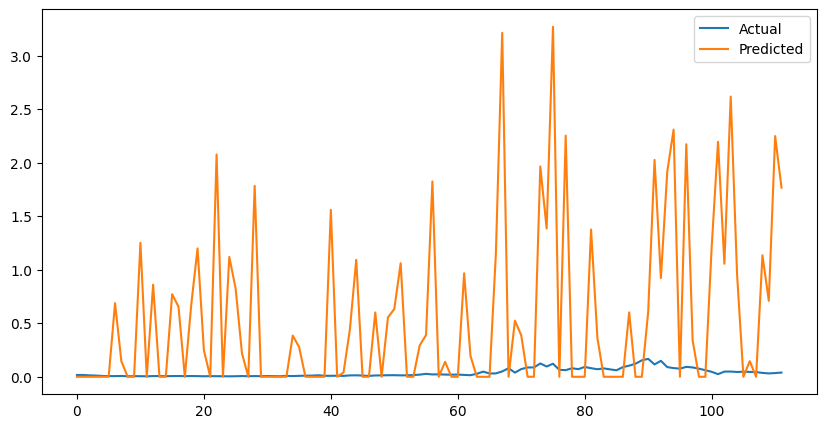

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.68760204, 0.14402655, 0.        , 0.        ,
       1.2506993 , 0.        , 0.8600453 , 0.        , 0.        ,
       0.77121145, 0.6541604 , 0.        , 0.66869324, 1.1992615 ,
       0.24794985, 0.        , 2.07582   , 0.        , 1.1197298 ,
       0.82438695, 0.21831161, 0.        , 1.7834849 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.38473395,
       0.27784643, 0.        , 0.        , 0.        , 0.        ,
       1.55881   , 0.        , 0.03966942, 0.44220448, 1.0923603 ,
       0.        , 0.        , 0.6005012 , 0.        , 0.55484647,
       0.6331103 , 1.0605383 , 0.        , 0.        , 0.29313675,
       0.38998318, 1.8241588 , 0.        , 0.13964261, 0.        ,
       0.        , 0.96665543, 0.19503775, 0.        , 0.        ,
       0.        , 1.1495628 , 3.212649  , 0.        , 0.5238966 ,
       0.38714582, 0.        , 0.        , 1.9641762 , 1.38437

In [ ]:
from matplotlib import pyplot as plt
X_real, Y_real = generate_real_samples(df, 20000)
Y_fake = generator.predict(X_real)
plt.figure(figsize=(10, 5))
i = 360
plt.plot(Y_real[i], label='Actual')
plt.plot(Y_fake[i], label='Predicted')
plt.legend()
plt.show()
Y_fake[i]